In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
styles = ['隸', '楷', '篆', '行', '草']
column_names = ["key", "character", "style", "author", "image"]
image_size = 48

In [22]:
dataframe = pd.read_csv("/tf/hanzi/data.csv", header=None, names = column_names)
authors = dataframe["author"].unique()
dataset_size = dataframe.shape[0]
dataframe

,key,character,style,author,image
0,宀,容,隸,何绍基,宀/容/png/隸/何绍基-87773-256x256.png
1,宀,容,隸,马王堆帛书,宀/容/png/隸/马王堆帛书-87777-256x256.png
2,宀,容,隸,辟雍碑,宀/容/png/隸/辟雍碑-87771-256x256.png
3,宀,容,隸,马王堆帛书,宀/容/png/隸/马王堆帛书-87779-256x256.png
4,宀,容,隸,居延简,宀/容/png/隸/居延简-87774-256x256.png
5,宀,容,隸,邓石如,宀/容/png/隸/邓石如-87772-256x256.png
6,宀,容,隸,马王堆帛书,宀/容/png/隸/马王堆帛书-87775-256x256.png
7,宀,容,楷,褚遂良,宀/容/png/楷/褚遂良-87758-256x256.png
8,宀,容,楷,虞世南,宀/容/png/楷/虞世南-87764-256x256.png
9,宀,容,楷,褚遂良,宀/容/png/楷/褚遂良-87757-256x256.png


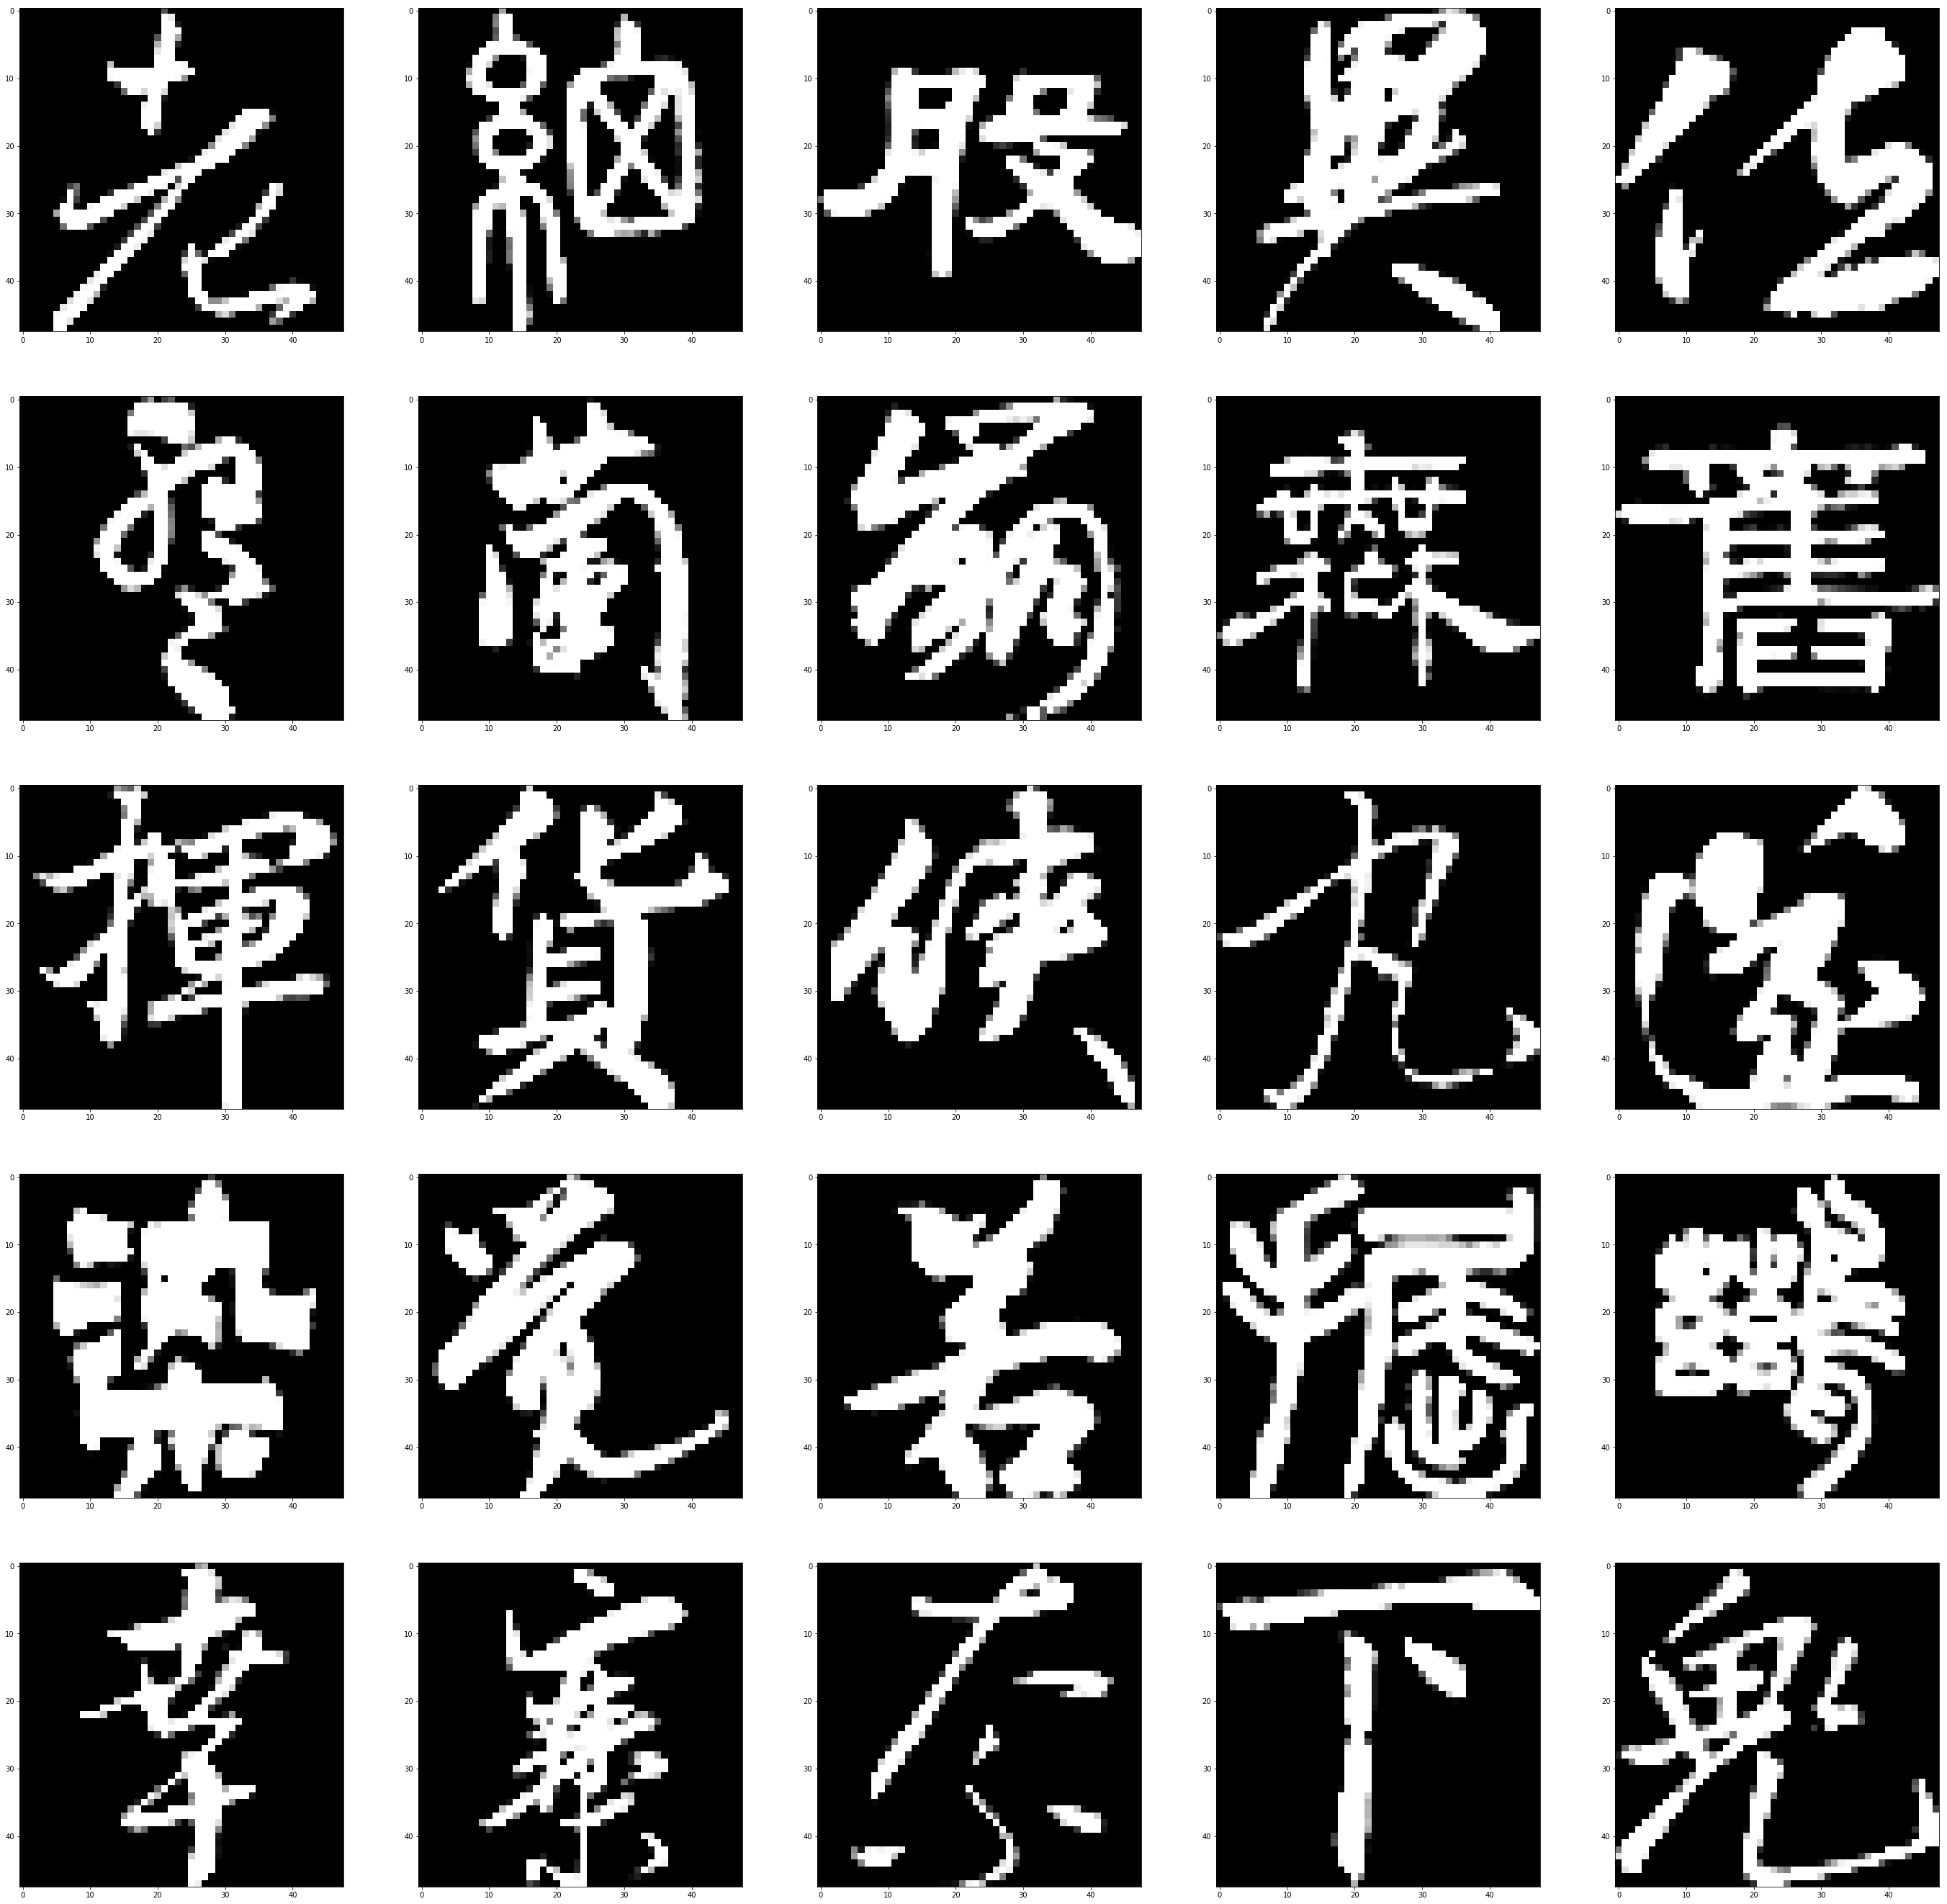

In [23]:
def get_processed_dataset(fileList, positions):
    dataset = get_raw_dataset(fileList, positions)
    return process_dataset(dataset)

def process_dataset(dataset):
    dataset = dataset.batch(128)
    dataset = dataset.repeat(15)
    return dataset.map(lambda x: (x["image"], x["style"])).apply(tf.data.experimental.ignore_errors())

def get_raw_dataset(fileList, positions):
    files = tf.data.Dataset.from_tensor_slices(fileList)
    dataset = files.interleave(tf.data.TextLineDataset, 1)
    return dataset.skip(positions[0]).take(positions[1]).map(parser(), num_parallel_calls=8)

def parser():
    styles_mapping = tf.constant(styles)
    styles_table = tf.contrib.lookup.index_table_from_tensor(mapping=styles_mapping, default_value=-1)
    
    authors_mapping = tf.convert_to_tensor(authors)
    authors_table = tf.contrib.lookup.index_table_from_tensor(mapping=authors_mapping, default_value=-1)
    
    def parse(value):
        nonlocal styles_table, authors_table
        columns_default = [[""], [""], [""], [""], [""]]
        columns = tf.decode_csv(value, record_defaults=columns_default, field_delim=',')
        features = dict(zip(column_names, columns))
        for f, tensor in features.items():
            if f == "style":
                features["style"] = styles_table.lookup(tensor)
            if f == "author":
                features["author"] = authors_table.lookup(tensor)
            if f == "image":
                image_string = tf.read_file(tf.strings.join([tf.constant("/tf/hanzi"), tensor], '/'))
                image_decoded = tf.image.decode_png(image_string, channels=1)
                image_resized = tf.image.resize_images(image_decoded, [image_size, image_size])
                image_standardized = tf.image.per_image_standardization(image_resized)
                image_reshaped = tf.reshape(image_standardized, [image_size, image_size], name = "Reshape")
                features["image"] = image_reshaped
        return features
    return parse

def get_train_dataset():
    return get_processed_dataset(["/tf/hanzi/shuffled_data.csv"], (0, 120000))

def get_validation_dataset():
    return get_processed_dataset(["/tf/hanzi/shuffled_data.csv"], (120000, 20000))

def get_test_dataset():
    return get_processed_dataset(["/tf/hanzi/shuffled_data.csv"], (140000, dataset_size - 140000))

train_dataset = get_train_dataset()

iterator = train_dataset.make_initializable_iterator()
el = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    tf.tables_initializer().run()
    plt.figure(figsize=(image_size, image_size))
    record = sess.run(el)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(record[0][i], cmap=plt.cm.binary)
    plt.show()

In [26]:
def cnn_model_fn(features, labels, mode):
  one_hot_style = tf.one_hot(labels, 5)

  # Input Layer
  input_layer = tf.reshape(features, [-1, image_size, image_size, 1], name = "ReshapeInputCL1")

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Convolutional Layer #3
  conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

  # Convolutional Layer #4
  conv4 = tf.layers.conv2d(
      inputs=pool3,
      filters=256,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
  pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)

  # Dense Layer #1
  pool2_flat = tf.reshape(pool4, [-1, 3 * 3 * 256], name = "ReshapeOutputPool2")
  dense1 = tf.layers.dense(inputs=pool2_flat, units=512, activation=tf.nn.relu)
  dropout1 = tf.layers.dropout(inputs=dense1, rate=0.25, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Dense Layer #2
  dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
  dropout2 = tf.layers.dropout(inputs=dense2, rate=0.25, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout2, units=5)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.softmax_cross_entropy(one_hot_style, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.00003)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [27]:
style_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn
)

train_spec = tf.estimator.TrainSpec(input_fn=get_train_dataset)
eval_spec = tf.estimator.EvalSpec(input_fn=get_validation_dataset)

tf.estimator.train_and_evaluate(style_classifier, train_spec, eval_spec)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_is_chief': True, '_evaluation_master': '', '_experimental_distribute': None, '_master': '', '_save_checkpoints_secs': 600, '_task_id': 0, '_device_fn': None, '_task_type': 'worker', '_service': None, '_save_checkpoints_steps': None, '_eval_distribute': None, '_model_dir': '/tmp/tmp55dpel74', '_tf_random_seed': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_protocol': None, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8ab407b4e0>, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_train_distribute': None, '_global_id_in_cluster': 0}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:

KeyboardInterrupt: 

In [7]:
style_classifier.evaluate(input_fn=get_validation_dataset)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-25T20:14:18Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnnntnwzv/model.ckpt-3510
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-25-20:21:37
INFO:tensorflow:Saving dict for global step 3510: accuracy = 0.5147, global_step = 3510, loss = 1.1278671
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3510: /tmp/tmpnnntnwzv/model.ckpt-3510


{'accuracy': 0.5147, 'global_step': 3510, 'loss': 1.1278671}